venv:
- conda create -n pinn python=3
- conda activate pinn
- conda install jupyter numpy matplotlib
- conda install pytorch torchvision torchaudio -c pytorch

In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [5]:
# Use cuda if available (use model.to(device) to run on device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
print(torch.version.cuda)         # Shows CUDA version PyTorch was built with
print(torch.cuda.is_available())  # Should be True if GPU is usable

12.4
False


In [7]:
class Model(nn.Module):
    # defines a fully connected neural network, with a tanh activation function
    def __init__(self, inputs, outputs, hidden, n_layers):
        super().__init__()
        act_f = nn.Tanh

        # First layer, "*" unpacks the list into arguments of nn.Sequential
        self.fcs = nn.Sequential(*[
                        nn.Linear(inputs, hidden),
                        act_f()])
        
        # Hidden layers with activation function
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(hidden, hidden),
                            act_f()]) for _ in range(n_layers-1)])
        
        # Final layer that maps from last hidden layer to output size
        self.fce = nn.Linear(hidden, outputs)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Done step 0
Done step 50000
Done step 100000
Done step 150000


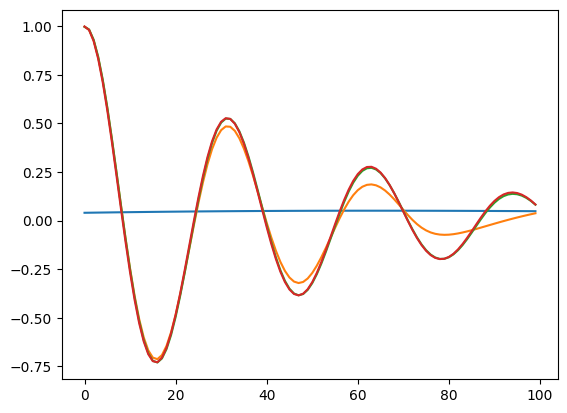

In [ ]:
# 1D spring simulation:
d, w0 = 2, 20 # Conditions for an under-dampened spring
mu, k = 2*d, w0**2

torch.manual_seed(42)
#model with 1 input and output layers (time and amplitude) and 4 hidden layers of 42 neurons
spring_model = Model(1, 1, 42, 4).to(device)
optimizer = torch.optim.Adam(spring_model.parameters(),lr=1e-4)

x_physics = torch.linspace(0,1,100).view(-1,1).requires_grad_(True) # generate time inputs
x_physics = x_physics.to(device)

last_res = np.array(0)

for i in range(150001):
    optimizer.zero_grad()
    
    # compute the "physics loss"
    yhp = spring_model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss_phys = (1e-4)*torch.mean(physics**2)

    #If time is 0, we want an amplitude of 1 (boundary condition)
    loss_BC = abs(1-yhp[0])
    
    # backpropagate joint loss
    loss = loss_phys + loss_BC# add two loss terms together
    loss.backward()
    optimizer.step()

    if i%50000 == 0:
        print(f"Done step {i}")
        to_display = yhp.cpu()
        to_display = to_display.detach().numpy()
        last_res = to_display
        plt.plot(to_display)



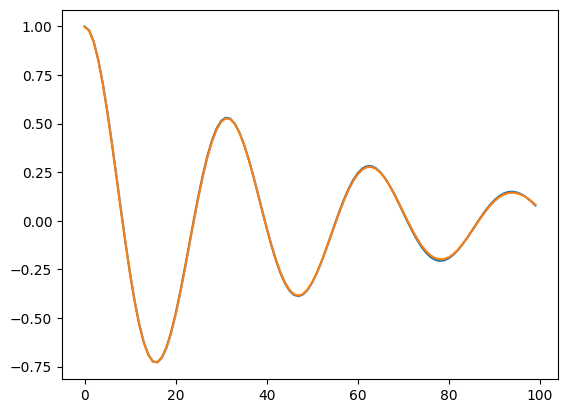

In [47]:
# Real spring, just to compare
def oscillator(d, w0, x):
    assert d < w0 # check if really underdampened
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

x = torch.linspace(0,1,100).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)

plt.plot(y)
plt.plot(last_res)

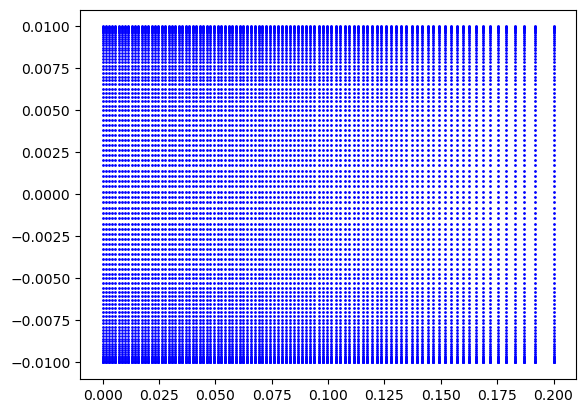

In [100]:
# Simulation parameters
h = 0.01
L = 0.2
u_avg = 0.01
rho = 1000
mu = 0.001

torch.manual_seed(12)
#model with 2 input (x,y position), 3 output layers (x, y velocity & pressure) and 8 hidden layers of 50 neurons
poiseuille_model = Model(2, 3, 50, 8).to(device)
optimizer = torch.optim.Adam(poiseuille_model.parameters(),lr=1e-4)

x_min, x_max = 0, L  # Horizontal span
y_min, y_max = -h, h  # Vertical span

# Getting x values, with higer density to the left
n_x = 100
skew_x = np.linspace(0, 1, n_x)  # uniform base
x_vals = x_min + (x_max - x_min) * (1 - (1 - skew_x)**0.7) # skew to the left

# Getting y values, with higher density on the top/bottom
n_y = 100
skew_y = np.linspace(0, 1, n_y)
y_vals = y_min + (y_max - y_min) * (0.5 - 0.5 * np.cos(np.pi * skew_y))

X, Y = np.meshgrid(x_vals, y_vals)

tensor_np = np.column_stack((X.ravel(), Y.ravel()))

tensor = torch.from_numpy(tensor_np).float().to(device).requires_grad_(True)

plt.scatter(tensor_np[:, 0], tensor_np[:, 1], s=1, color='blue')

In [101]:
def compute_PDE(x, y):
    # x: [N, 2], with requires_grad=True
    # y: [N, 3], predicted values [u, v, p]

    # First-order derivatives
    grads = torch.autograd.grad(
        outputs=y,              # shape [N, 3]
        inputs=x,               # shape [N, 2], requires_grad=True
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]  # shape [N, 2] — total derivative of y wrt x[:, 0] and x[:, 1]

    dudx = grads[:, 0]
    dudy = grads[:, 1]
    
    grads_v = torch.autograd.grad(y[:, 1], x, grad_outputs=torch.ones_like(y[:, 1]), create_graph=True)[0]
    dvdx = grads_v[:, 0]
    dvdy = grads_v[:, 1]

    grads_p = torch.autograd.grad(y[:, 2], x, grad_outputs=torch.ones_like(y[:, 2]), create_graph=True)[0]
    dpdx = grads_p[:, 0]
    dpdy = grads_p[:, 1]

    # Second-order derivatives
    d2udx2 = torch.autograd.grad(dudx, x, grad_outputs=torch.ones_like(dudx), create_graph=True)[0][:, 0]
    d2udy2 = torch.autograd.grad(dudy, x, grad_outputs=torch.ones_like(dudy), create_graph=True)[0][:, 1]

    d2vdx2 = torch.autograd.grad(dvdx, x, grad_outputs=torch.ones_like(dvdx), create_graph=True)[0][:, 0]
    d2vdy2 = torch.autograd.grad(dvdy, x, grad_outputs=torch.ones_like(dvdy), create_graph=True)[0][:, 1]

    return dudx, dudy, dpdx, dpdy, d2udx2, d2udy2, dvdx, dvdy, d2vdx2, d2vdy2

tensor(0.0032, grad_fn=<MulBackward0>)
tensor(0.0007, grad_fn=<MulBackward0>)
tensor(0.0010, grad_fn=<MulBackward0>)
tensor(0.0014, grad_fn=<MulBackward0>)
tensor(0.0029, grad_fn=<MulBackward0>)
tensor(0.0026, grad_fn=<MulBackward0>)
tensor(0.0004, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MulBackward0>)
tensor(0.0021, grad_fn=<MulBackward0>)
tensor(0.0008, grad_fn=<MulBackward0>)


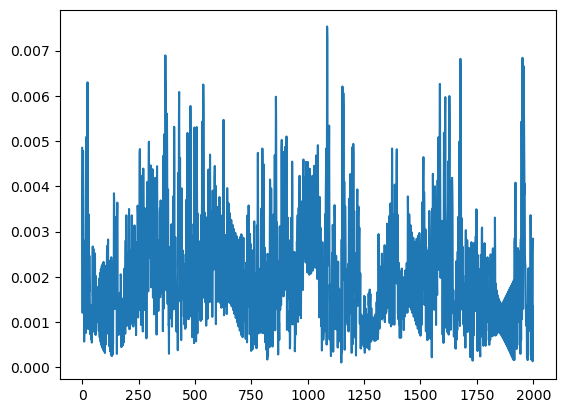

In [106]:
loss_arr = []
for i in range(2000):
    optimizer.zero_grad()
    
    # compute the "physics loss"
    yhp = poiseuille_model(tensor)
    
    dudx, dudy, dpdx, dpdy, d2udx2, d2udy2, dvdx, dvdy, d2vdx2, d2vdy2 = compute_PDE(tensor, yhp)

    navier_x = rho*(yhp[:, 0] * dudx + yhp[:, 0] * dudy) + dpdx - mu * (d2udx2 + d2udy2)
    navier_y = rho*(yhp[:, 1] * dvdx + yhp[:, 1] * dvdy) + dpdy - mu * (d2vdx2 + d2vdy2)
    momentum = dudx + dvdy

    loss = (1e-2) * (torch.mean(navier_x**2) + torch.mean(navier_y**2) + torch.mean(momentum**2))

    no_slip = 0
    inlet = 0

    for idx, j in enumerate(tensor):
        if j[1] == -h or j[1] == h:
            no_slip = 2 * (abs(yhp[idx][0]) + abs(yhp[idx][1]))
        
        if j[0] == 0:
            inlet = abs(yhp[idx][0] - u_avg) + abs(yhp[idx][1])

    loss = loss + no_slip + inlet
    if i % 200 == 0:
        print(no_slip)

    loss.backward()
    loss_arr.append(loss.detach().numpy())
    optimizer.step()

plt.plot(range(2000), loss_arr)

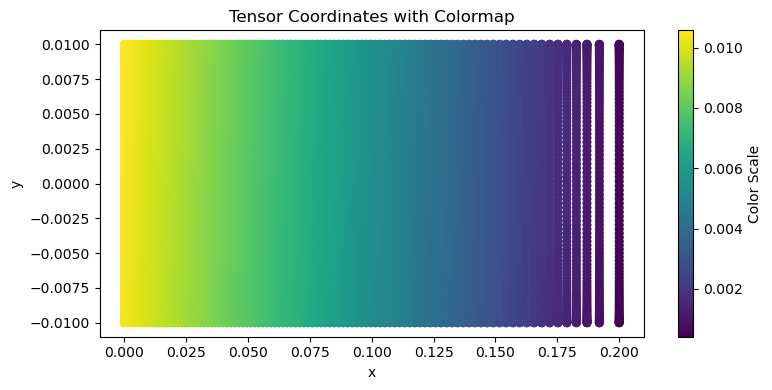

In [107]:
import seaborn as sns
import pandas as pd

c = yhp[:, 0].detach()

# Convert to a pandas DataFrame for seaborn
df = pd.DataFrame(tensor.detach().numpy(), columns=['x', 'y'])
df['color'] = c.numpy()

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot with seaborn
scatter = sns.scatterplot(data=df, x='x', y='y', hue='color', palette='viridis', edgecolor = None, ax=ax, legend=False)

# Normalize and add colorbar
norm = plt.Normalize(df['color'].min(), df['color'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])  # Needed for colorbar

# Now correctly attach the colorbar to the figure
fig.colorbar(sm, ax=ax, label='Color Scale')

# Labels and title
ax.set_title("Tensor Coordinates with Colormap")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.tight_layout()
plt.show()